# Performance evaluation
A. Boulle and A. Souesme, 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from utilities import Log10Layer
%matplotlib ipympl

2025-10-30 16:32:25.171624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and format data

In [2]:
# ======== Begin user input ========
# Path to input data
data_path = "/PATH/TO/DATA/FOLDER"
# Index corresponding to "size" and "strain" in test&_label
indices_labels = [20, 22]
# Angular range used when creating the dataset. For display purpose only
tth = np.arange(15, 120.01, 0.01)
# ======== End user input ========

# Load test data
sampling = 1
raw_test = np.load(data_path + "/test.npz")
test_data = raw_test["test_data"][:, :]
test_label = raw_test["test_label"][:, :]
test_data = test_data[::sampling, :]
test_label = test_label[::sampling, indices_labels]

# Load trained model
cnn = keras.models.load_model(
    "./checkpoints/CNN.hdf5", custom_objects={"Log10Layer": Log10Layer}
)

# Load normalization scheme
with open("./checkpoints/normL.class", "rb") as f:
    normL = pickle.load(f)

2025-10-30 16:32:29.337221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 16:32:29.540099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13342 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:03:00.0, compute capability: 6.1


### Plot data

size = 0.028 µm
strain = 0.076 %


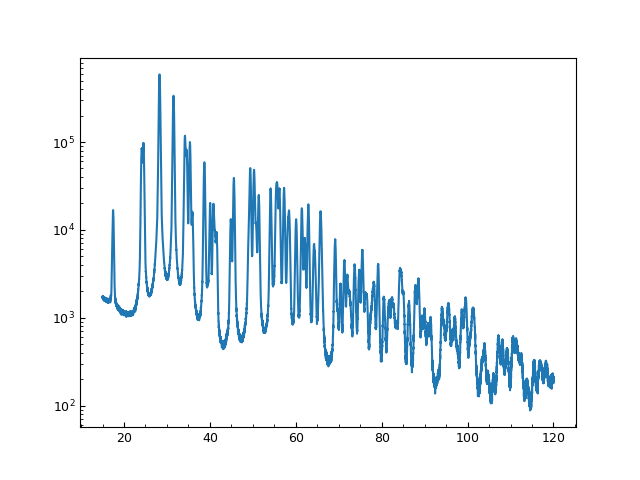

In [3]:
nb_data = np.shape(test_label)[0]
random_data = np.random.randint(nb_data)
print(f"size = {test_label[random_data][0]:.3f} µm")
print(f"strain = {test_label[random_data][1]*1e-4:.3f} %")
plt.cla()
plt.semilogy(tth, test_data[random_data, :])
plt.show()

### Inference on test data

In [4]:
# Preprocess test data and labels
test_data = test_data[:, :, np.newaxis, np.newaxis]
test_label = normL.forward(test_label)

Label normalization scheme: MinMax


In [5]:
# Evaluate overall performance
cnn.evaluate(test_data, test_label, batch_size=32)

2025-10-30 16:32:37.146631: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


250/250 [==============================] - 3s 9ms/step - loss: 0.0078


0.007837177254259586

### Plot predictions _vs_ test data

250/250 [==============================] - 2s 7ms/step
Label normalization scheme: MinMax
Label normalization scheme: MinMax


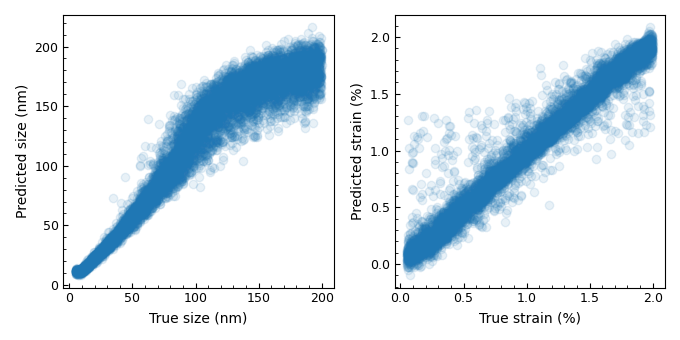

Label normalization scheme: MinMax
Label normalization scheme: MinMax


In [6]:
# Make predictions on test data
raw_pred = cnn.predict(test_data)
predictions = normL.backwards(raw_pred)
# Denormalize test labels
test_label = normL.backwards(test_label)

# Plot predictions vs true labels
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(6.8, 3.4))
ax0.plot(test_label[:, 0] * 1000, predictions[:, 0] * 1000, "o", alpha=0.1)
ax0.set_xlabel("True size (nm)")
ax0.set_ylabel("Predicted size (nm)")
ax1.plot(test_label[:, 1] * 1e-4, predictions[:, 1] * 1e-4, "o", alpha=0.1)
ax1.set_xlabel("True strain (%)")
ax1.set_ylabel("Predicted strain (%)")
plt.tight_layout()
plt.show()


# re-normalize labels for multiple cell runs
predictions = normL.forward(raw_pred)
test_label = normL.forward(test_label)